<a href="https://colab.research.google.com/github/ipeirotis/datasets/blob/master/notebooks/DOH_Restaurant_Inspections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www1.nyc.gov/site/doh/business/food-operators/the-inspection-process.page

See https://www1.nyc.gov/assets/doh/downloads/pdf/rii/blue-book.pdf 

## Download Latest Dataset

In [1]:
!curl 'https://data.cityofnewyork.us/api/views/43nn-pn8j/rows.csv?accessType=DOWNLOAD' -o restaurants.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  102M    0  102M    0     0  6396k      0 --:--:--  0:00:16 --:--:-- 6734k


In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv("restaurants.csv", dtype = 'object')

In [3]:
initial_size = len(df)
initial_size

244983

In [4]:
# Render our plots inline
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
df.dtypes

CAMIS                    object
DBA                      object
BORO                     object
BUILDING                 object
STREET                   object
ZIPCODE                  object
PHONE                    object
CUISINE DESCRIPTION      object
INSPECTION DATE          object
ACTION                   object
VIOLATION CODE           object
VIOLATION DESCRIPTION    object
CRITICAL FLAG            object
SCORE                    object
GRADE                    object
GRADE DATE               object
RECORD DATE              object
INSPECTION TYPE          object
Latitude                 object
Longitude                object
Community Board          object
Council District         object
Census Tract             object
BIN                      object
BBL                      object
NTA                      object
Location Point           object
dtype: object

In [6]:
# Adding underscores in all column names
cols = df.columns
cols = cols.map(lambda x: x.replace(' ', '_').upper())
df.columns = cols

In [7]:
df.dtypes

CAMIS                    object
DBA                      object
BORO                     object
BUILDING                 object
STREET                   object
ZIPCODE                  object
PHONE                    object
CUISINE_DESCRIPTION      object
INSPECTION_DATE          object
ACTION                   object
VIOLATION_CODE           object
VIOLATION_DESCRIPTION    object
CRITICAL_FLAG            object
SCORE                    object
GRADE                    object
GRADE_DATE               object
RECORD_DATE              object
INSPECTION_TYPE          object
LATITUDE                 object
LONGITUDE                object
COMMUNITY_BOARD          object
COUNCIL_DISTRICT         object
CENSUS_TRACT             object
BIN                      object
BBL                      object
NTA                      object
LOCATION_POINT           object
dtype: object

In [8]:
df.drop('LOCATION_POINT', axis=1, inplace=True)   

## Cleaning Individual Columns

In [9]:
df.CAMIS.isnull().sum()

0

In [10]:
df.DBA.isnull().sum()

1601

In [11]:
# Checks that all CAMIS values correpond to a unique DBA value
# ie the same CAMIS always has the same DBA
max_cardinality = df[['DBA','CAMIS']].pivot_table(
    index='CAMIS',
    values='DBA',
    aggfunc=pd.Series.nunique
).DBA.max()

assert(max_cardinality==1)

### INSPECTION_TYPE

In [12]:
df.INSPECTION_TYPE.value_counts()

Cycle Inspection / Initial Inspection                          145982
Cycle Inspection / Re-inspection                                45177
Pre-permit (Operational) / Initial Inspection                   25302
Pre-permit (Operational) / Re-inspection                         8887
Administrative Miscellaneous / Initial Inspection                4517
Pre-permit (Non-operational) / Initial Inspection                2246
Cycle Inspection / Reopening Inspection                          2040
Pre-permit (Operational) / Compliance Inspection                 1228
Smoke-Free Air Act / Initial Inspection                           946
Administrative Miscellaneous / Re-inspection                      853
Pre-permit (Operational) / Reopening Inspection                   817
Inter-Agency Task Force / Initial Inspection                      718
Trans Fat / Initial Inspection                                    588
Cycle Inspection / Compliance Inspection                          401
Calorie Posting / In

In [13]:
sum(df.INSPECTION_TYPE.isnull())

4179

In [14]:
# We create a column "TO_DELETE" to mark the entries that we are not interested in.
# We will perform first the inspection/analysis on all the attributes, and then delete the rows

# Drop all cases where inspection is NULL
df['TO_DELETE'] = df.INSPECTION_TYPE.isnull()

In [15]:
sum(df['TO_DELETE'])

4179

In [16]:
# Break INSPECTION_TYPE into two columns, and also delete some inspection types

# Create a new column that contains the results of the split on the '/'' character
lst = df.INSPECTION_TYPE.str.split(' / ').values.tolist()
lst = [ l if type(l)==type(list()) else ['',''] for l in lst ]
t = pd.DataFrame(lst)


In [17]:
t[0].value_counts()

Cycle Inspection                193600
Pre-permit (Operational)         36375
Administrative Miscellaneous      5483
                                  4179
Pre-permit (Non-operational)      2454
Smoke-Free Air Act                1141
Inter-Agency Task Force            718
Trans Fat                          700
Calorie Posting                    333
Name: 0, dtype: int64

In [18]:
t[1].value_counts()

Initial Inspection              180597
Re-inspection                    55400
                                  4179
Reopening Inspection              2891
Compliance Inspection             1737
Second Compliance Inspection       152
Limited Inspection                  27
Name: 1, dtype: int64

In [19]:
# Keep only cycle inspections. Ignore admin, pre-permit, transfat, and calorie posting inspections
# We will only keep the initial inspections and the re-inspections. The other types are border cases

keep = df.INSPECTION_TYPE.isin( ['Cycle Inspection / Initial Inspection', 'Cycle Inspection / Re-inspection'])


In [20]:
# Check how many we will drop: ~keep means negation on the keep and summing up adds up the 'True'
sum(~keep)

53824

In [21]:
# Adding the "not keep" entries into the TO_DELETE

# The |= operator is a shortcut for df['TO_DELETE'] = df['TO_DELETE'] | ~keep
# We use the bit-OR operator (|), as we want to keep the existing deletions, and add the ones from the 
# additional condition
df['TO_DELETE'] |= ~keep

In [22]:
# Rename the two entries that we will keep into simpler values

df["INSPECTION_TYPE"].replace(
    to_replace='Cycle Inspection / Initial Inspection',
    value = 'Initial Inspection',
    inplace=True
)
df["INSPECTION_TYPE"].replace(
    to_replace='Cycle Inspection / Re-inspection',
    value = 'Re-inspection',
    inplace=True
)

In [23]:
sum(df['TO_DELETE'])

53824

### BORO

In [24]:
df.BORO.value_counts()

Manhattan        92151
Brooklyn         62920
Queens           58158
Bronx            23452
Staten Island     8224
0                   78
Name: BORO, dtype: int64

In [25]:
sum(df.BORO.isnull())

0

In [26]:
# Replace the "Missing" in BORO with null
# df.BORO = df.BORO.replace('Missing', np.NaN)

In [27]:
missing = set(df[df.BORO.isnull()].CAMIS)
# missing

In [28]:
sum(df.BORO == '0')

78

In [29]:
# Remove the entries with null/missing BORO value
# Not worth trying to fix.
df['TO_DELETE'] |= (df.BORO == '0')

In [30]:
sum(df['TO_DELETE'])

53862

### BUILDING

In [31]:
sum(df.BUILDING.isnull())

485

In [32]:
# Inspect the entries with missing street number
# df[df.BUILDING.isnull()]

In [33]:
# Dropping the violations listed without street number
# Most are in train stations and in airports, but there
# are a few others in 'regular' locations

df['TO_DELETE'] |= df.BUILDING.isnull()

In [34]:
sum(df['TO_DELETE'])

54229

### STREET

In [35]:
# Check that no street values are empty
sum(df.STREET.isnull())

30

In [36]:
df['TO_DELETE'] |= df.STREET.isnull()

In [37]:
sum(df['TO_DELETE'])

54229

### ZIPCODE

In [38]:
sum(df.ZIPCODE.isnull())

3472

In [39]:
len(set(df[df.ZIPCODE.isnull()].CAMIS))

464

In [40]:
df['TO_DELETE'] |= df.ZIPCODE.isnull()

In [41]:
# TODO: Fill in the missing zip codes, perhaps with geocoding of the addresses
# For now, we just drop the cases without ZIPCODE

### CUISINE DESCRIPTION

In [42]:
df.CUISINE_DESCRIPTION.value_counts()

American          45181
Chinese           23689
Pizza             14984
Coffee/Tea        12378
Latin American    10526
                  ...  
Czech                18
Basque               10
Lebanese              9
New French            6
Armenian              4
Name: CUISINE_DESCRIPTION, Length: 87, dtype: int64

In [43]:
len(df.CUISINE_DESCRIPTION.value_counts())

87

In [44]:
sum(df.CUISINE_DESCRIPTION.isnull())

4179

In [45]:
'''
df.CUISINE_DESCRIPTION.replace(
    to_replace='Café/Coffee/Tea',
    value = 'Cafe',
    inplace=True
)

df.CUISINE_DESCRIPTION.replace(
    to_replace='Latin (Cuban, Dominican, Puerto Rican, South & Central American)',
    value = 'Latin',
    inplace=True
)
'''

"\ndf.CUISINE_DESCRIPTION.replace(\n    to_replace='Café/Coffee/Tea',\n    value = 'Cafe',\n    inplace=True\n)\n\ndf.CUISINE_DESCRIPTION.replace(\n    to_replace='Latin (Cuban, Dominican, Puerto Rican, South & Central American)',\n    value = 'Latin',\n    inplace=True\n)\n"

### INSPECTION_DATE

In [46]:
df["INSPECTION_DATE"] = pd.to_datetime(df["INSPECTION_DATE"], format="%m/%d/%Y")

In [47]:
df.INSPECTION_DATE.describe(datetime_is_numeric=True)

count                           244983
mean     2018-06-24 18:04:40.995824384
min                1900-01-01 00:00:00
25%                2019-06-12 00:00:00
50%                2020-01-08 00:00:00
75%                2022-02-22 00:00:00
max                2022-09-09 00:00:00
Name: INSPECTION_DATE, dtype: object

In [48]:
sum(df.INSPECTION_DATE.isnull())

0

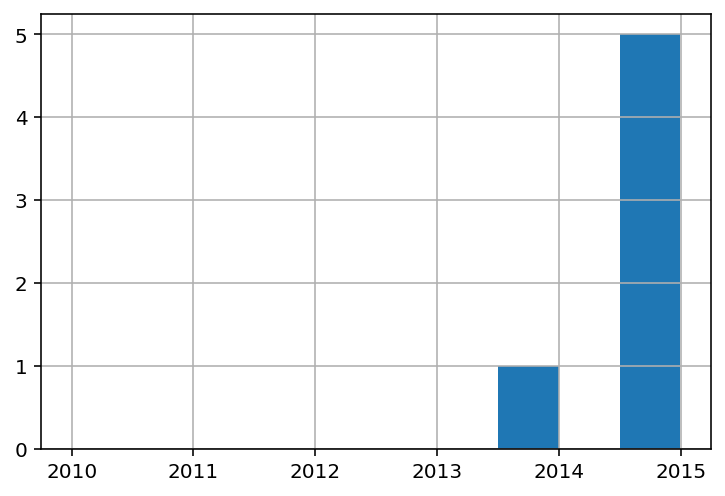

In [49]:
df.INSPECTION_DATE.hist(range=(pd.to_datetime('2010-01-01'),pd.to_datetime('2014-12-31')))

In [50]:
# Drop the 1900-01-01 inspections. These are all incorrect and we cannot fix them
df['TO_DELETE'] |= (df['INSPECTION_DATE'] == '1900-01-01')

In [51]:
# After analysis, it seems that we have minimal number of inspections before 2015
df['TO_DELETE'] |=  (df['INSPECTION_DATE'] < '2015-01-01')

In [52]:
sum(df['TO_DELETE'])

57130

### ACTION

In [53]:
sum(df.ACTION.isnull())

4179

In [54]:
df["ACTION"].value_counts()

Violations were cited in the following area(s).                                                                                       227408
Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.      9172
Establishment re-opened by DOHMH.                                                                                                       2450
No violations were recorded at the time of this inspection.                                                                             1740
Establishment re-closed by DOHMH.                                                                                                         34
Name: ACTION, dtype: int64

In [55]:
df["ACTION"].replace(
    to_replace='Violations were cited in the following area(s).',
    value = 'Violations found',
    inplace=True
)

In [56]:
df["ACTION"].replace(
    to_replace='No violations were recorded at the time of this inspection.',
    value = 'No violations',
    inplace=True
)

In [57]:
df["ACTION"].replace(
    to_replace='Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.',
    value = 'Establishment closed',
    inplace=True
)

In [58]:
df["ACTION"].replace(
    to_replace='Establishment re-opened by DOHMH.',
    value = 'Establishment re-opened',
    inplace=True
)

In [59]:
df["ACTION"].replace(
    to_replace='Establishment re-closed by DOHMH.',
    value = 'Establishment re-closed',
    inplace=True
)

In [60]:
df["ACTION"].value_counts()

Violations found           227408
Establishment closed         9172
Establishment re-opened      2450
No violations                1740
Establishment re-closed        34
Name: ACTION, dtype: int64

In [61]:
# Drop the Establishment re-opened and re-closed cases
# as the inspection scores for these can be misleading
df['TO_DELETE'] |=  (df.ACTION == 'Establishment re-closed')
df['TO_DELETE'] |=  (df.ACTION == 'Establishment re-opened')
df['TO_DELETE'] |=  df.ACTION.isnull()

In [62]:
sum(df['TO_DELETE'])

57130

### SCORE

In [63]:
df["SCORE"] = pd.to_numeric(df["SCORE"])

In [64]:
df.SCORE.describe()

count    233147.000000
mean         21.748746
std          16.338615
min           0.000000
25%          11.000000
50%          17.000000
75%          28.000000
max         172.000000
Name: SCORE, dtype: float64

In [65]:
len(df)

244983

In [66]:
len( df[ df.SCORE < 0 ] )

0

In [67]:
df['TO_DELETE'] |= (df.SCORE < 0)

In [68]:
sum(df['TO_DELETE'])

57130

In [69]:
# Drop cases reported as "no violations but with positive score"
df['TO_DELETE'] |= ((df.SCORE > 0)  & (df.ACTION == 'No violations'))

# Drop cases with zero score but with violations found
df['TO_DELETE'] |= ((df.SCORE == 0)  & (df.ACTION == 'Violations found'))

In [70]:
# Drop incorrectly scored inspections
df['TO_DELETE'] |=  (df.GRADE=='A') & (df.SCORE>13)

df['TO_DELETE'] |=  (df.GRADE=='B') & ( (df.SCORE<14) | (df.SCORE>27) )

# Drop incorrectly scored inspections
df['TO_DELETE'] |=  (df.GRADE=='C') & (df.SCORE<28)


In [71]:
sum(df['TO_DELETE'])

60169

### RECORD_DATE

In [72]:
df["RECORD_DATE"] = pd.to_datetime(df["RECORD_DATE"], format="%m/%d/%Y")

In [73]:
# Drop record date field, as it only contains a single value
df = df.drop( 'RECORD_DATE', axis = 'columns')

### GRADE

In [74]:
df.GRADE.value_counts()

A    91151
B    11766
N     7080
C     5151
Z     4036
P     1093
Name: GRADE, dtype: int64

In [75]:
sum(df.GRADE.isnull())

124706

In [76]:
df.query(" GRADE == 'G' ")

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE_DESCRIPTION,INSPECTION_DATE,ACTION,...,INSPECTION_TYPE,LATITUDE,LONGITUDE,COMMUNITY_BOARD,COUNCIL_DISTRICT,CENSUS_TRACT,BIN,BBL,NTA,TO_DELETE


In [77]:
# Seems that all the "G" correspond to "A"
df.GRADE.replace('G', 'A', inplace=True)

In [78]:
# P assigned to 'Establishment re-opened' actions
df.query(" GRADE == 'P' ")

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE_DESCRIPTION,INSPECTION_DATE,ACTION,...,INSPECTION_TYPE,LATITUDE,LONGITUDE,COMMUNITY_BOARD,COUNCIL_DISTRICT,CENSUS_TRACT,BIN,BBL,NTA,TO_DELETE
823,50090847,ESS -A- Bagel,Brooklyn,55,WATER STREET,11201,9177437388,Sandwiches,2019-07-20,Establishment re-opened,...,Pre-permit (Operational) / Reopening Inspection,40.703293906326,-73.992047363499,302,33,002100,3000019,3000260050,BK38,True
1015,50099168,COFFEE TOWN,Brooklyn,508,55 STREET,11220,9292980122,American,2019-11-13,Establishment re-opened,...,Pre-permit (Operational) / Reopening Inspection,40.642016335071,-74.012780951086,307,38,010000,3015008,3008320008,BK34,True
1468,41504235,SAMURAI SUSHI,Brooklyn,1709,86 STREET,11214,7183317100,Japanese,2019-02-28,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,40.608401592521,-74.00453067647,311,43,017800,3165733,3063430024,BK27,True
1908,50049097,KUMO JAPANESE CUISINE,Brooklyn,1406,CORTELYOU ROAD,11226,7182828288,Japanese,2019-10-25,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,40.640886379724,-73.965127729136,314,40,052000,3118673,3051570003,BK42,True
2157,50058095,TEXAS CHICKEN & BURGERS,Brooklyn,521,OCEAN AVENUE,11226,7188262493,Chicken,2019-06-27,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,40.649860468666,-73.960957098708,314,40,051002,3117136,3051010001,BK42,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244337,50017455,NEST RESTAURANT & BAR,Queens,12517,101ST AVE,11419,7188474035,Caribbean,2020-02-06,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,40.691461225686,-73.820691755256,409,28,015400,4199967,4094680022,QN54,True
244421,50098630,JUICE HEALTHY FOOD AND DRINKS,Manhattan,156,EAST 33 STREET,10016,2128821611,"Juice, Smoothies, Fruit Salads",2019-10-09,Establishment re-opened,...,Pre-permit (Operational) / Reopening Inspection,40.7454876763,-73.979663674365,106,02,007200,1018486,1008880047,MN20,True
244570,50065358,ANDIAMO CAFE,Bronx,2467,GRAND CONCOURSE,10468,7186187989,American,2019-04-22,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,40.86172225875,-73.897543430151,205,14,023703,2013810,2031660085,BX40,True
244711,50070665,HIBACHI BUFFET,Bronx,216,EAST 161 STREET,10451,7185901627,Chinese,2019-10-21,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,40.826193323314,-73.92045986696,204,16,006100,2002456,2024430090,BX14,True


In [79]:
# P assigned to 'Establishment re-opened' actions
df.query(" GRADE == 'P' ").ACTION.value_counts()

Establishment re-opened    1093
Name: ACTION, dtype: int64

In [80]:
# P assigned to 'Reopening Inspection' inspection types
df.query(" GRADE == 'P' ").INSPECTION_TYPE.value_counts()

Cycle Inspection / Reopening Inspection            880
Pre-permit (Operational) / Reopening Inspection    213
Name: INSPECTION_TYPE, dtype: int64

In [81]:
# df.query(" GRADE == 'Z' ").SCORE.hist(bins=100)

In [82]:
# TODO: Figure out what Z, and Not Yet Graded means in GRADE
# Until then, we just replace these values with NULL, keeping only the A, B, C grades

# 
df.GRADE.value_counts()

A    91151
B    11766
N     7080
C     5151
Z     4036
P     1093
Name: GRADE, dtype: int64

In [83]:
df['TO_DELETE'] |=  (df.GRADE=='Z')
df['TO_DELETE'] |=  (df.GRADE=='P')
df['TO_DELETE'] |=  (df.GRADE=='N') # Not Yet Graded
df['TO_DELETE'] |=  (df.GRADE=='Not Yet Graded')

### GRADE_DATE

In [84]:
df["GRADE_DATE"] = pd.to_datetime(df["GRADE_DATE"], format="%m/%d/%Y")


In [85]:
# Grade date and inspection date should be the same. 
assert np.abs((df.GRADE_DATE - df.INSPECTION_DATE).dropna()).sum().days == 0

In [86]:
# Check that is there is a grade date, a grade is also assigned
assert sum ( ~df.GRADE_DATE.isnull() & df.GRADE.isnull() )  == 0

In [87]:
# We do not need GRADE DATE if we have INSPECTION DATE
df = df.drop("GRADE_DATE", axis='columns')

### VIOLATION_CODE and VIOLATION_DESCRIPTION

In [88]:
df.VIOLATION_CODE.isnull().sum()

5931

In [89]:
# All the cases where violation code is NULL should be either cases that we delete
# or a "No violations" case
check = df[df.VIOLATION_CODE.isnull() & ~df.TO_DELETE & (df.ACTION!='No violations')]

assert( len(check) == 0 )


In [90]:
df.VIOLATION_DESCRIPTION.isnull().sum()

5931

In [91]:
# Checks that all VIOLATION_CODE has unique VIOLATION_DESCRIPTION
df[['VIOLATION_CODE','VIOLATION_DESCRIPTION']].drop_duplicates().pivot_table(
    index='VIOLATION_CODE',
    values='VIOLATION_DESCRIPTION',
    aggfunc=pd.Series.nunique
).sort_values('VIOLATION_DESCRIPTION', ascending=False)


,VIOLATION_DESCRIPTION
VIOLATION_CODE,
02A,2
08B,2
05A,2
05B,2
05D,2
...,...
15-42,1
15-39,1
15-37,1


In [92]:
df['TO_DELETE'] |=  (df.VIOLATION_DESCRIPTION == 'Caloric content not posted on menus, menu boards or food tags, in a food service establishment that is 1 of 15 or more outlets operating the same type of business nationally under common ownership or control, or as a franchise or doing business under the same name, for each menu item that is served in portions, the size and content of which are standardized.')

In [93]:
# In the dataset we have a NULL violation, when there is no violation
# To make this more explicit, we replace NULL with 000
# df.VIOLATION_CODE.fillna('000', inplace=True)

In [94]:
df.VIOLATION_CODE.isnull().sum()

5931

In [95]:
## LATITUDE and LONGITUDE

In [96]:
df['LONGITUDE'] = pd.to_numeric(df['LONGITUDE'])
df['LATITUDE'] = pd.to_numeric(df['LATITUDE'])

### MISC analysis

In [97]:
# Find the unique values in each column
# 
# df.describe(include = [np.object, 'category']).T['unique']
unique = df.describe(include = 'all').T['unique'].sort_values()

for column in unique.index:
    if unique[column] < 200:
        print(df[column].value_counts())
        print("=====")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  after removing the cwd from sys.path.


False    179683
True      65300
Name: TO_DELETE, dtype: int64
=====
Critical          123915
Not Critical      115137
Not Applicable      5931
Name: CRITICAL_FLAG, dtype: int64
=====
Violations found           227408
Establishment closed         9172
Establishment re-opened      2450
No violations                1740
Establishment re-closed        34
Name: ACTION, dtype: int64
=====
Manhattan        92151
Brooklyn         62920
Queens           58158
Bronx            23452
Staten Island     8224
0                   78
Name: BORO, dtype: int64
=====
A    91151
B    11766
N     7080
C     5151
Z     4036
P     1093
Name: GRADE, dtype: int64
=====
Initial Inspection                                             145982
Re-inspection                                                   45177
Pre-permit (Operational) / Initial Inspection                   25302
Pre-permit (Operational) / Re-inspection                         8887
Administrative Miscellaneous / Initial Inspection                45

In [98]:
df.dtypes

CAMIS                            object
DBA                              object
BORO                             object
BUILDING                         object
STREET                           object
ZIPCODE                          object
PHONE                            object
CUISINE_DESCRIPTION              object
INSPECTION_DATE          datetime64[ns]
ACTION                           object
VIOLATION_CODE                   object
VIOLATION_DESCRIPTION            object
CRITICAL_FLAG                    object
SCORE                           float64
GRADE                            object
INSPECTION_TYPE                  object
LATITUDE                        float64
LONGITUDE                       float64
COMMUNITY_BOARD                  object
COUNCIL_DISTRICT                 object
CENSUS_TRACT                     object
BIN                              object
BBL                              object
NTA                              object
TO_DELETE                          bool


## Deleting Entries

In this section, we use the results of the analysis above, and delete (additional) entries that will not be useful in our analysis. (Note that it is important to document this, as others may want to go back to the original source, if the entries that we leave are not sufficient.)

In [99]:
len(df)

244983

In [100]:
assert len(df) == initial_size

In [101]:
df = df[ df.TO_DELETE == False].copy()

In [102]:
len(df)

179683

In [103]:
df[df.VIOLATION_CODE.isnull()].VIOLATION_DESCRIPTION

7         NaN
133       NaN
144       NaN
200       NaN
232       NaN
         ... 
240527    NaN
241408    NaN
241889    NaN
243661    NaN
244701    NaN
Name: VIOLATION_DESCRIPTION, Length: 371, dtype: object

## Additional Data Quality Checks

In [104]:


assert sum(df.INSPECTION_TYPE.isnull()) == 0

assert len(set(df.INSPECTION_TYPE.values)) == 2

df["INSPECTION_TYPE"] =  pd.Categorical(df["INSPECTION_TYPE"], ordered=False)

In [105]:
# Check that no borough entries are empty
assert sum(df.BORO.isnull()) == 0

df["BORO"] =  pd.Categorical(df["BORO"], ordered=False)

In [106]:
# Check that no street numbers are empty
assert sum(df.BUILDING.isnull()) == 0

In [107]:
assert sum(df.STREET.isnull()) == 0

In [108]:

assert sum(df.CUISINE_DESCRIPTION.isnull()) == 0

df["CUISINE_DESCRIPTION"] =  pd.Categorical(df["CUISINE_DESCRIPTION"], ordered=False)

In [109]:
# We only keep three different actions
assert len(set(df.ACTION.values)) == 3

# No action is empty
assert sum(df.ACTION.isnull()) == 0

df["ACTION"] =  pd.Categorical(df["ACTION"], ordered=False)

In [110]:
# The below drops any grade values other than A, B, C, and converts the remaining entries to null
df["GRADE"] =  pd.Categorical(df["GRADE"], categories = ['A', 'B', 'C'], ordered=True)

# https://www1.nyc.gov/assets/doh/downloads/pdf/rii/how-we-score-grade.pdf
# 0-13 get an A
assert sum( (df.GRADE=='A') & (df.SCORE>13)) == 0

# 14-27 get a B
assert sum( (df.GRADE=='B') & ( (df.SCORE<14) | (df.SCORE>27) ) ) == 0

# 28- get a C
assert sum( (df.GRADE=='C') & (df.SCORE<28) ) == 0

# TODO: In principle, a NULL grade is only when the score is above 14, and it was an initial inspection

In [111]:
# Check that is there is a grade date, a grade is also assigned
# assert sum ( ~df.GRADE_DATE.isnull() & df.GRADE.isnull() ) == 0

In [112]:
df["VIOLATION_CODE"] =  pd.Categorical(df["VIOLATION_CODE"], ordered=False)
df["CRITICAL_FLAG"] =  pd.Categorical(df["CRITICAL_FLAG"], ordered=False)


In [113]:
df [ df.VIOLATION_CODE.isnull() ].VIOLATION_DESCRIPTION

7         NaN
133       NaN
144       NaN
200       NaN
232       NaN
         ... 
240527    NaN
241408    NaN
241889    NaN
243661    NaN
244701    NaN
Name: VIOLATION_DESCRIPTION, Length: 371, dtype: object

## Normalization

### Violation Codes

In [114]:
# Recreating the table at https://www1.nyc.gov/assets/doh/downloads/pdf/rii/ri-violation-penalty.pdf

violation_codes = df [ ['VIOLATION_CODE', 'VIOLATION_DESCRIPTION', 'CRITICAL_FLAG'] ].drop_duplicates()
violation_codes = violation_codes.rename( {
    'VIOLATION_DESCRIPTION' : 'DESCRIPTION',
    'CRITICAL_FLAG' : 'CRITICAL'
},  axis = 'columns').sort_values('VIOLATION_CODE').dropna().set_index('VIOLATION_CODE')
violation_codes

,DESCRIPTION,CRITICAL
VIOLATION_CODE,,
02A,Time/Temperature Control for Safety (TCS) food...,Not Critical
02A,Food not cooked to required minimum temperature.,Critical
02B,Hot food item not held at or above 140º F.,Critical
02B,Hot TCS food item not held at or above 140 °F.,Not Critical
02C,Hot food item that has been cooked and refrige...,Critical
...,...,...
22F,MISBRANDED AND LABELING,Not Critical
22G,Sale or use of certain expanded polystyrene it...,Not Critical
28-05,Food adulterated or misbranded. Adulterated o...,Not Critical


In [115]:
violation_codes

,DESCRIPTION,CRITICAL
VIOLATION_CODE,,
02A,Time/Temperature Control for Safety (TCS) food...,Not Critical
02A,Food not cooked to required minimum temperature.,Critical
02B,Hot food item not held at or above 140º F.,Critical
02B,Hot TCS food item not held at or above 140 °F.,Not Critical
02C,Hot food item that has been cooked and refrige...,Critical
...,...,...
22F,MISBRANDED AND LABELING,Not Critical
22G,Sale or use of certain expanded polystyrene it...,Not Critical
28-05,Food adulterated or misbranded. Adulterated o...,Not Critical


In [116]:
# Drop the description and critical part from the main dataframe
df = df.drop(['VIOLATION_DESCRIPTION' ,  'CRITICAL_FLAG'], axis='columns')

In [117]:
df

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE_DESCRIPTION,INSPECTION_DATE,ACTION,...,INSPECTION_TYPE,LATITUDE,LONGITUDE,COMMUNITY_BOARD,COUNCIL_DISTRICT,CENSUS_TRACT,BIN,BBL,NTA,TO_DELETE
7,40811162,CARMINE'S,Manhattan,2450,BROADWAY,10024,2123622200,Italian,2021-08-13,No violations,...,Re-inspection,40.791168,-73.974308,107,06,017900,1033560,1012380046,MN12,False
12,50077077,THE TAILOR PUBLIC HOUSE,Manhattan,505,8 AVENUE,10018,2014172596,French,2019-12-03,Violations found,...,Re-inspection,40.753040,-73.992850,104,03,011100,1013575,1007590037,MN13,False
20,50038040,PZA,Queens,NKA,JFK INTL ARPT,11430,7186790452,Pizza,2018-08-16,Violations found,...,Re-inspection,40.648313,-73.788281,483,28,071600,4000000,4142600001,QN98,False
23,50010546,DIRTY FRENCH,Manhattan,180,LUDLOW STREET,10002,2122543000,French,2021-08-25,Violations found,...,Initial Inspection,40.721804,-73.987467,103,01,003001,1087953,1004120048,MN27,False
24,41699414,SBARRO,Queens,9015,QUEENS BOULEVARD,11373,7182710681,Italian,2019-04-18,Violations found,...,Initial Inspection,40.733840,-73.871577,404,25,068300,4045999,4018600100,QN29,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244978,41678685,THE BUTCHER'S DAUGHTER,Manhattan,19,KENMARE STREET,10012,2122193434,Vegetarian,2022-04-26,Violations found,...,Initial Inspection,40.720534,-73.994682,102,01,004100,1007131,1004780012,MN24,False
244979,41062076,STARBUCKS,Brooklyn,67,FRONT STREET,11201,7188550856,Coffee/Tea,2020-03-06,Violations found,...,Initial Inspection,40.702547,-73.990958,302,33,002100,3000085,3000367502,BK38,False
244980,50091096,BENARES RESTAURANT,Manhattan,45,MURRAY STREET,10007,2127664900,Indian,2022-01-25,Violations found,...,Initial Inspection,40.714048,-74.009382,101,01,002100,1001435,1001330007,MN24,False
244981,50061387,FAMILY ALTAGRACIA CARIBBEAN CUISINE,Brooklyn,5601,CLARENDON ROAD,11203,9177212661,Caribbean,2022-05-20,Violations found,...,Initial Inspection,40.644816,-73.923675,317,45,094600,3105570,3047670042,BK96,False


### Restaurants

In [118]:
df.columns.values

array(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE_DESCRIPTION', 'INSPECTION_DATE', 'ACTION',
       'VIOLATION_CODE', 'SCORE', 'GRADE', 'INSPECTION_TYPE', 'LATITUDE',
       'LONGITUDE', 'COMMUNITY_BOARD', 'COUNCIL_DISTRICT', 'CENSUS_TRACT',
       'BIN', 'BBL', 'NTA', 'TO_DELETE'], dtype=object)

In [119]:
columns = ['CAMIS', 'DBA', 'BUILDING', 'STREET', 'ZIPCODE', 'BORO', 'PHONE', 
           'CUISINE_DESCRIPTION', 'LATITUDE', 'LONGITUDE',
       'COMMUNITY_BOARD', 'COUNCIL_DISTRICT', 'CENSUS_TRACT', 'BIN',
       'BBL', 'NTA']
restaurants =  df [ columns ].drop_duplicates()

In [120]:
# Check that we have the same attributes for a given CAMIS
# and the we do not have duplicate CAMIS values
assert len(restaurants) == len(set(restaurants.CAMIS.values))

In [121]:
restaurants.head(5)

,CAMIS,DBA,BUILDING,STREET,ZIPCODE,BORO,PHONE,CUISINE_DESCRIPTION,LATITUDE,LONGITUDE,COMMUNITY_BOARD,COUNCIL_DISTRICT,CENSUS_TRACT,BIN,BBL,NTA
7,40811162,CARMINE'S,2450,BROADWAY,10024,Manhattan,2123622200,Italian,40.791168,-73.974308,107,06,017900,1033560,1012380046,MN12
12,50077077,THE TAILOR PUBLIC HOUSE,505,8 AVENUE,10018,Manhattan,2014172596,French,40.753040,-73.992850,104,03,011100,1013575,1007590037,MN13
20,50038040,PZA,NKA,JFK INTL ARPT,11430,Queens,7186790452,Pizza,40.648313,-73.788281,483,28,071600,4000000,4142600001,QN98
23,50010546,DIRTY FRENCH,180,LUDLOW STREET,10002,Manhattan,2122543000,French,40.721804,-73.987467,103,01,003001,1087953,1004120048,MN27
24,41699414,SBARRO,9015,QUEENS BOULEVARD,11373,Queens,7182710681,Italian,40.733840,-73.871577,404,25,068300,4045999,4018600100,QN29


In [122]:
restaurants.PHONE.value_counts().head(20)

2124656273    43
9176186310    33
9172843260    29
2126159700    17
2125867610    16
7182153308    15
2125825472    14
2124656302    14
7186566210    13
__________    12
9177437388    11
9178863304     9
2129818588     8
7187011630     8
2125325003     8
2123959280     8
9175665727     7
2123544624     7
7182246030     7
6465881074     7
Name: PHONE, dtype: int64

In [123]:
# __ = restaurants.PHONE.value_counts().head(10).index.values[7]

In [124]:
# restaurants.PHONE.replace(to_replace=__, value=np.nan, inplace=True)

In [125]:
# Citi Field concessions
# restaurants.query("PHONE == '7185958100'").head(5)

In [126]:
# Madison Square Garden concession stands
# restaurants.query("PHONE == '2124656273'").head(5)

In [127]:
# restaurants.plot(kind='scatter', x='LONGITUDE', y='LATITUDE', alpha=0.2, s=1, figsize=(15,15))

In [128]:
df = df.drop (columns[1:], axis='columns')

In [129]:
df

,CAMIS,INSPECTION_DATE,ACTION,VIOLATION_CODE,SCORE,GRADE,INSPECTION_TYPE,TO_DELETE
7,40811162,2021-08-13,No violations,NaN,0.0,A,Re-inspection,False
12,50077077,2019-12-03,Violations found,09B,10.0,A,Re-inspection,False
20,50038040,2018-08-16,Violations found,02B,9.0,A,Re-inspection,False
23,50010546,2021-08-25,Violations found,02B,19.0,NaN,Initial Inspection,False
24,41699414,2019-04-18,Violations found,09C,38.0,NaN,Initial Inspection,False
...,...,...,...,...,...,...,...,...
244978,41678685,2022-04-26,Violations found,10F,21.0,NaN,Initial Inspection,False
244979,41062076,2020-03-06,Violations found,10F,7.0,A,Initial Inspection,False
244980,50091096,2022-01-25,Violations found,02B,23.0,NaN,Initial Inspection,False
244981,50061387,2022-05-20,Violations found,04A,48.0,NaN,Initial Inspection,False


### Inspections

In [130]:
# Each inspection has multiple violations. We want to keep just the inspections for now
inspection = df.drop('VIOLATION_CODE', axis='columns').drop_duplicates().sort_values(['INSPECTION_DATE', 'CAMIS'])

In [131]:
inspection

,CAMIS,INSPECTION_DATE,ACTION,SCORE,GRADE,INSPECTION_TYPE,TO_DELETE
156225,40693546,2015-04-21,Violations found,5.0,A,Initial Inspection,False
41303,41171220,2015-06-25,Violations found,10.0,NaN,Initial Inspection,False
75698,41171220,2015-07-08,Violations found,13.0,A,Re-inspection,False
26232,40944945,2015-10-14,Violations found,5.0,A,Re-inspection,False
94250,50009999,2015-10-15,Violations found,8.0,NaN,Initial Inspection,False
...,...,...,...,...,...,...,...
31041,50074586,2022-09-09,Violations found,13.0,A,Re-inspection,False
8536,50078722,2022-09-09,Violations found,43.0,NaN,Initial Inspection,False
99337,50094524,2022-09-09,Violations found,13.0,A,Re-inspection,False
89247,50101322,2022-09-09,Violations found,25.0,NaN,Initial Inspection,False


In [132]:
# We create an ID for each inspection here
inspection = inspection.reset_index().drop('index', axis='columns').reset_index().rename({'index': 'INSPECTION_ID'}, axis='columns')

In [133]:
inspection.ACTION.value_counts()

Violations found        53818
Establishment closed     1002
No violations             372
Name: ACTION, dtype: int64

In [134]:
# Ensure that the inspection table contains 
# no duplicate pairs for 'INSPECTION_DATE', 'CAMIS'
pvt = inspection.pivot_table(
    index = ['INSPECTION_DATE', 'CAMIS'],
    values = 'INSPECTION_ID',
    aggfunc = 'count'
)
pvt [ pvt.INSPECTION_ID > 1 ]

# assert len(pvt [ pvt.INSPECTION_ID > 1 ]) == 0 

,,INSPECTION_ID
INSPECTION_DATE,CAMIS,
2017-11-04,40911114,2


In [135]:
# df[ (df.CAMIS =='41007054') & (df.INSPECTION_DATE == '2017-03-03')  ].sort_values('VIOLATION_CODE')

In [136]:
# to_drop = inspection.query(" CAMIS =='50051092' and  INSPECTION_DATE == '2019-09-11' ").index.values[1]
# inspection = inspection.drop(to_drop, axis='index')

In [137]:
to_drop = inspection.query(" CAMIS =='40911114' and  INSPECTION_DATE == '2017-11-04' ").index.values[1]

inspection = inspection.drop(to_drop, axis='index')

In [138]:
inspection.drop('TO_DELETE', axis='columns', inplace=True)

In [139]:
# Ensure that the inspection table contains 
# no duplicate pairs for 'INSPECTION_DATE', 'CAMIS'
pvt = inspection.pivot_table(
    index = ['INSPECTION_DATE', 'CAMIS'],
    values = 'INSPECTION_ID',
    aggfunc = 'count'
)
assert len(pvt [ pvt.INSPECTION_ID > 1 ]) == 0 

In [140]:
inspection.INSPECTION_TYPE.value_counts()

Initial Inspection    40767
Re-inspection         14424
Name: INSPECTION_TYPE, dtype: int64

In [141]:
inspection_stats = inspection.pivot_table(
    index = 'CAMIS',
    aggfunc = ['min', 'max', 'count'],
    values = 'INSPECTION_DATE'
)

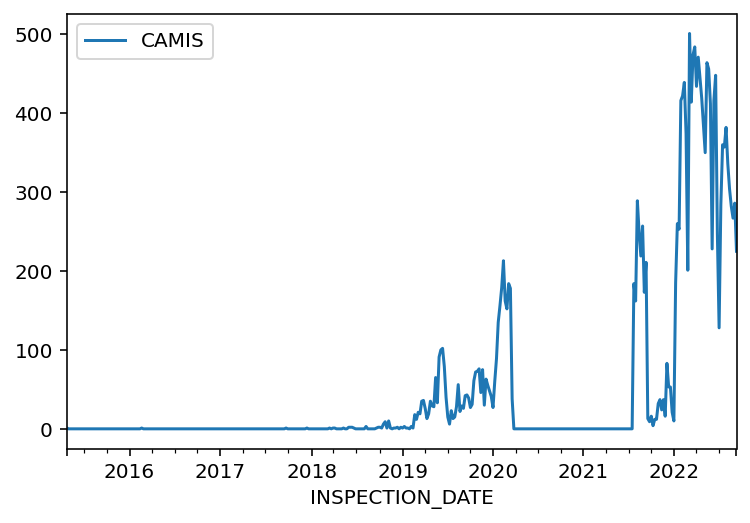

In [142]:
# Distribution of last inspection across all restaurants
inspection_stats['max'].sort_values('INSPECTION_DATE').reset_index().pivot_table(
    index='INSPECTION_DATE',
    aggfunc='count'
).resample('1W').sum().plot()

In [143]:
# Longevity 
# (inspection_stats['max'] - inspection_stats['min'])['INSPECTION DATE'].sort_values()

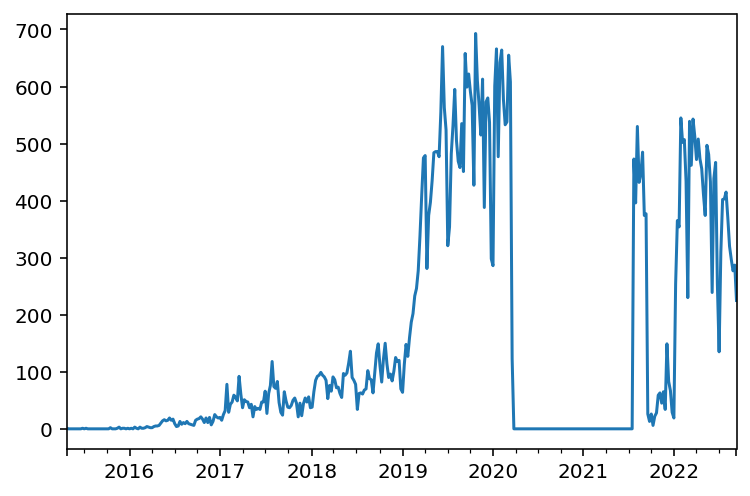

In [144]:
# Distribution of all inspections
inspection['INSPECTION_DATE'].value_counts().sort_index().resample('1W').sum().plot()

In [145]:
len(df)

179683

In [146]:
violations = pd.merge(
    inspection,
    df[ ['CAMIS', 'INSPECTION_DATE', 'VIOLATION_CODE' ] ],
    on= ['CAMIS', 'INSPECTION_DATE'],
    how = 'inner'
)
violations = violations[ ['INSPECTION_ID', 'VIOLATION_CODE'] ].drop_duplicates()
len(violations)

168480

In [147]:
print(f"Violations: {len(violations)}")
print(f"Inspections: {len(inspection)}")
print(f"Restaurants: {len(restaurants)}")
print(f"Violation Codes: {len(violation_codes)}")

Violations: 168480
Inspections: 55191
Restaurants: 18480
Violation Codes: 125


## Storing in MySQL


In [148]:
!sudo pip3 install -U -q PyMySQL sqlalchemy sql_magic

In [149]:
import os
from sqlalchemy import create_engine

conn_string = 'mysql+pymysql://{user}:{password}@{host}/?charset=utf8mb4'.format(
    host = 'db.ipeirotis.org', 
    user = 'root',
    password = 'ae6jQniBS5muV27', #os.environ['MYSQL_PASSWORD'],
    encoding = 'utf8mb4')

engine = create_engine(conn_string)
con = engine.connect()

In [157]:
# Query to create a database
db_name = 'doh_restaurants'

sql = f"DROP DATABASE IF EXISTS {db_name}"
engine.execute(sql)

# Create a database
sql = f"CREATE DATABASE IF NOT EXISTS {db_name} DEFAULT CHARACTER SET 'utf8mb4'"
engine.execute(sql)

# And lets switch to the database
sql = f"USE {db_name}"
engine.execute(sql)

In [158]:
create_table_sql = '''
CREATE TABLE restaurants (
    CAMIS                      char(8),
    DBA varchar(90), 
    BUILDING varchar(10), 
    STREET varchar(40), 
    ZIPCODE char(5), 
    BORO ENUM('Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island')  ,
    PHONE char(10), 
    CUISINE_DESCRIPTION    varchar(30),
LATITUDE                float,
LONGITUDE               float,
COMMUNITY_BOARD          char(3),
COUNCIL_DISTRICT         char(2),
CENSUS_TRACT             char(6),
BIN                      char(7),
BBL                      char(10),
NTA                      char(4), 
PRIMARY KEY(CAMIS)   
) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
'''
engine.execute(create_table_sql)

create_table_sql = '''
CREATE TABLE inspections (
    INSPECTION_ID               char(8),
    CAMIS                      char(8),
    INSPECTION_DATE    datetime,
    ACTION                   ENUM('Violations found','Establishment closed','No violations'),
    SCORE                     smallint,
    GRADE                    char(1),
    INSPECTION_TYPE          ENUM('Initial Inspection','Re-inspection'),
    FOREIGN KEY(CAMIS) REFERENCES restaurants(CAMIS),
    PRIMARY KEY(INSPECTION_ID) 
) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
'''
engine.execute(create_table_sql)

create_table_sql = '''
CREATE TABLE violation_codes (
  VIOLATION_CODE     char(5),
  DESCRIPTION varchar(1000),
  CRITICAL ENUM('Critical', 'Not Applicable', 'Not Critical')
  -- PRIMARY KEY(VIOLATION_CODE)

) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
'''
engine.execute(create_table_sql)


create_table_sql = '''
CREATE TABLE violations (
  INSPECTION_ID         char(8),
  VIOLATION_CODE     char(5),
  FOREIGN KEY(INSPECTION_ID) REFERENCES inspections(INSPECTION_ID)
  -- FOREIGN KEY(VIOLATION_CODE) REFERENCES violation_codes(VIOLATION_CODE)
) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
'''
engine.execute(create_table_sql)

In [159]:
violation_codes.reset_index().VIOLATION_CODE.str.len().max()

5

In [160]:
violation_codes.reset_index().to_sql(
        name = 'violation_codes', 
        schema = db_name, 
        con = engine,
        if_exists = 'append',
        index = False, 
        chunksize = 1000)

In [161]:
restaurants.to_sql(
        name = 'restaurants', 
        schema = db_name, 
        con = engine,
        if_exists = 'append',
        index = False, 
        chunksize = 1000)

In [162]:
inspection.to_sql(
        name = 'inspections', 
        schema = db_name, 
        con = engine,
        if_exists = 'append',
        index = False, 
        chunksize = 1000)

In [163]:
violations.to_sql(
        name = 'violations', 
        schema = db_name, 
        con = engine,
        if_exists = 'append',
        index = False, 
        chunksize = 1000)

In [164]:
sql = '''
GRANT SELECT ON doh_restaurants.* TO 'student'@'%%'
'''
engine.execute(sql)

In [165]:


sql = '''
CREATE VIEW restaurant_inspection_latest AS 
	WITH latest_inspection AS (
		SELECT CAMIS, MAX(INSPECTION_DATE) AS INSPECTION_DATE FROM inspections
		GROUP BY CAMIS
	)
	SELECT R.CAMIS, R.DBA, R.BUILDING, R.STREET, R.ZIPCODE, R.BORO, R.CUISINE_DESCRIPTION, R.LATITUDE, R.LONGITUDE, I.INSPECTION_DATE, I.INSPECTION_ID, I.INSPECTION_TYPE, V.VIOLATION_CODE, I.SCORE, I.GRADE
		FROM restaurants R
			JOIN latest_inspection L ON R.CAMIS = L.CAMIS
			JOIN inspections I ON I.CAMIS = L.CAMIS AND L.INSPECTION_DATE = I.INSPECTION_DATE
			JOIN violations V ON I.INSPECTION_ID = V.INSPECTION_ID
      '''

engine.execute(sql)